PCA, Nearest-Neighbors Classification and Clustering
====================================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\newcommand{\eqdef}{\equiv}$

This tour details [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (dimentionality reduction), supervised classification using nearest neighbors
and unsupervised [clustering](https://en.wikipedia.org/wiki/Unsupervised_learning) using [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering).


We recommend that after doing this Numerical Tours, you apply it to your
own data, for instance using a dataset from [LibSVM](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/).


_Disclaimer:_ these machine learning tours are intended to be
overly-simplistic implementations and applications of baseline machine learning methods.
For more advanced uses and implementations, we recommend
to use a state-of-the-art library, the most well known being
[Scikit-Learn](http://scikit-learn.org/).

In [1]:
library(plot3D)
library(pracma)
options(warn=-1) # turns off warnings, to turn on: "options(warn=0)"

# Importing the libraries
for (f in list.files(path="nt_toolbox/toolbox_general/", pattern="*.R")) {
    source(paste("nt_toolbox/toolbox_general/", f, sep=""))
}
for (f in list.files(path="nt_toolbox/toolbox_signal/", pattern="*.R")) {
    source(paste("nt_toolbox/toolbox_signal/", f, sep=""))
}

Dataset Loading
---------------
We use here the famous
[IRIS dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) of Fisher.
The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor).
 Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres.


Helpers.

Load the dataset.

In [2]:
data(iris)
A = iris
# Transforming the species to numerical categories :
A$Species = as.numeric(A$Species)

Randomly permute it.

In [3]:
A = A[sample(nrow(A)),]

Separate the features $ (x_i)_{i=1}^n $from the class information.
The feature are stored as the row of a matrix $X \in \RR^{n \times p}$
Be sure to start the class at index 1.

In [4]:
X = as.matrix(A[,1:(dim(A)[2] - 1)])
y = as.matrix(A[,dim(A)[2]])
y = y - min(y) + 1

$n$ is the number of samples, $p$ is the dimensionality of the features,
$k$ is the number of classes.

In [5]:
n = dim(X)[1]
p = dim(X)[2]
k = max(y)

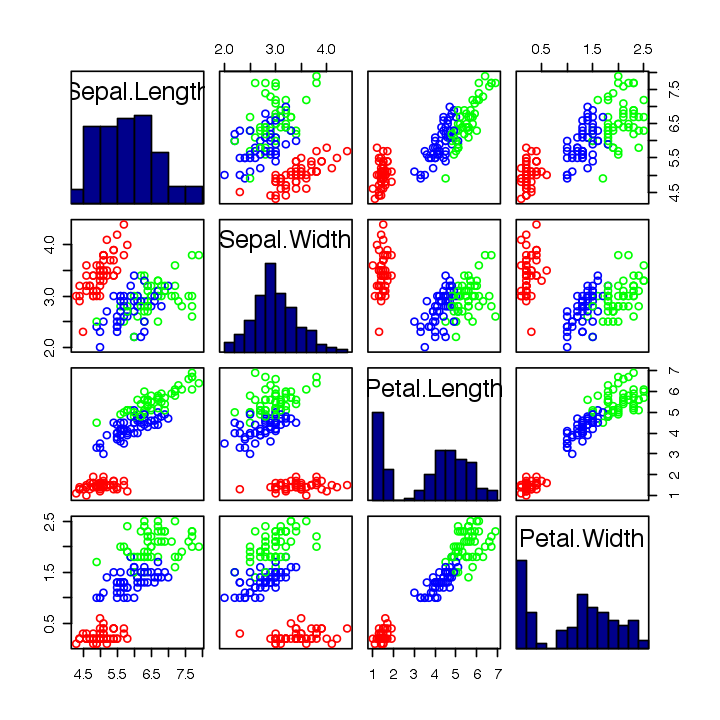

In [6]:
options(repr.plot.width=6, repr.plot.height=6)

panel.hist = function(x, ...)
{
    usr = par("usr"); on.exit(par(usr))
    par(usr = c(usr[1:2], 0, 1.5) )
    h = hist(x, plot = FALSE)
    breaks = h$breaks; nB <- length(breaks)
    y = h$counts
    y = y/max(y)
    rect(breaks[-nB], 0, breaks[-1], y, col = "darkblue")
}
pairs(X, col=c("red","blue","green")[y], diag.panel=panel.hist)

Dimenionality Reduction and PCA
-------------------------------
In order to display in 2-D or 3-D the data, [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction)
is needed.
The simplest method is the [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA),
which perform an
orthogonal linear projection on the principal axsis (eigenvector) of the
covariance matrix.


Compute [empirical mean](https://en.wikipedia.org/wiki/Sample_mean_and_covariance)
$$    m = \frac{1}{n} \sum_{i=1}^n x_i \in \RR^p $$
and [covariance](https://en.wikipedia.org/wiki/Sample_mean_and_covariance)
$$ C = \frac{1}{n} \sum_{i=1}^n (x_i-m) (x_i-m)^\top \in \RR^{p \times p}. $$
Denoting $\tilde X = X - 1_p m^\top $, one has $C=\tilde X^\top
\tilde X$.

In [7]:
Xm = function(X){X - rep(colMeans(X), rep.int(nrow(X), ncol(X)))}
Cov = function(X){data.matrix(1. / (n - 1) * t(Xm(X)) %*% Xm(X))}

Display the covariance matrix.

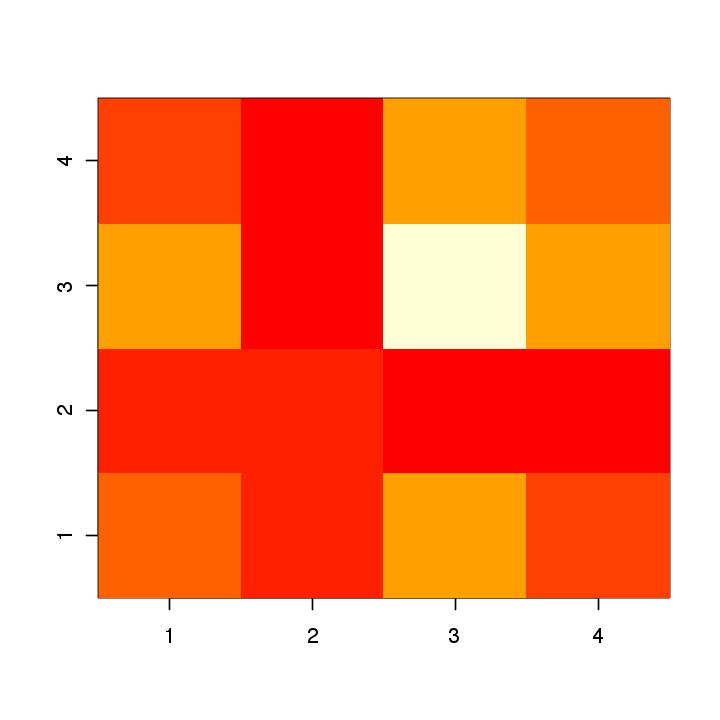

In [8]:
image(c(1:4), c(1:4), Cov(X), xlab='', ylab='')

Compute PCA ortho-basis using the
[SVD decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition)
$$ \tilde X = U \text{diag}(d) V  $$
where $U \in \RR^{n \times p}$ and $V \in \RR^{p \times p}$ have
orthonormal columns. $V$ are the principal directions of variance
 and
are order by decreasing variances.

In [9]:
svd_decomp = svd(Xm(X))
U = svd_decomp$u
D = svd_decomp$d
V = svd_decomp$v

Compute the feature in the PCA basis, $z_i=V^\top (x_i-m) $, stored in matrix
format as $Z=\tilde X V$.

In [10]:
Z = Xm(X) %*% V

Plot the singular values of the covariances, which corresponds to the standard deviation of the data
along the principal directions.

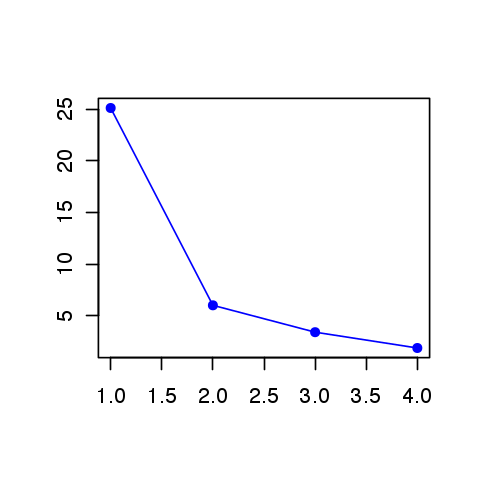

In [11]:
options(repr.plot.width=4, repr.plot.height=4)
plot(D, type="o", col=4, ylab="", xlab="", pch=16)

The first dimensions of the $z_i$ are the optimal way to linearly
embed the data in a low dimensional space.
This can be used for display in 2-D using the first two dimension.

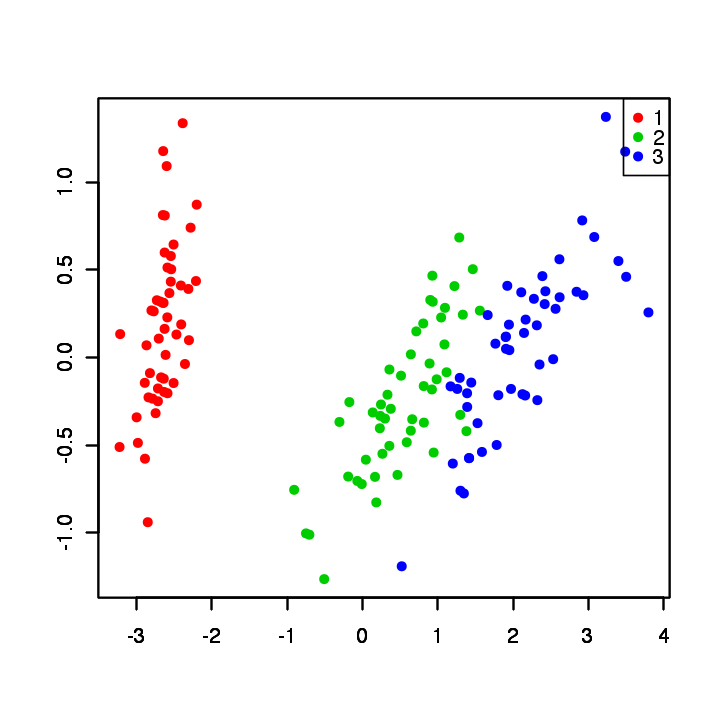

In [12]:
options(repr.plot.width=6, repr.plot.height=6)

for (i in 1:k)
{
    I = (y==i)
    plot(Z[I,1], Z[I,2], col=i + 1, xlim=c(min(Z[,1]), max(Z[,1])),  
         ylim=c(min(Z[,2]), max(Z[,2])), xlab="", ylab="", pch=16)
    par(new=TRUE)
}

cols = c(2:(k + 1))
legend("topright", legend=c(1:k), col=cols, pch=16)

Similar display in 3-D.

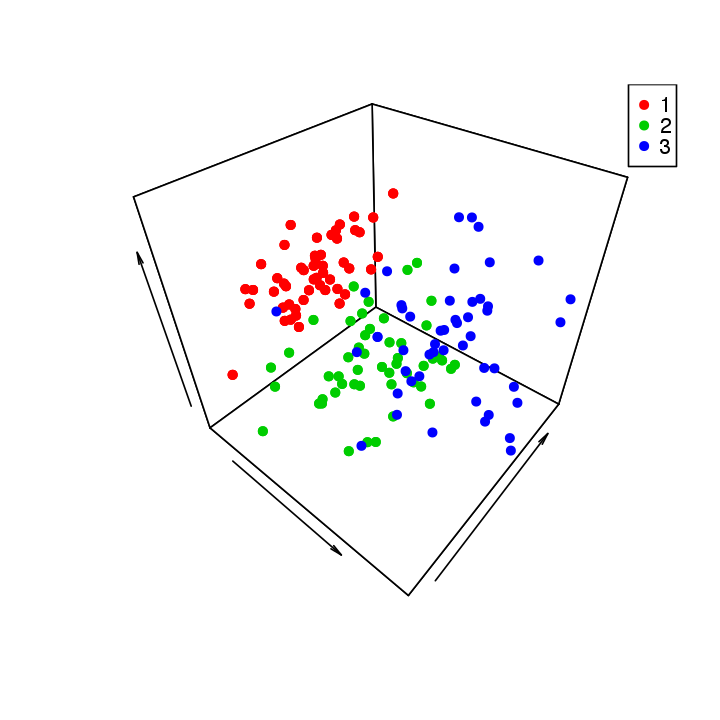

In [13]:
for (i in 1:k)
{
    I = (y==i)
    if (i == 1)
    {
        scatter3D(Z[I,1], Z[I,2], Z[I,3], col=i + 1, xlim=c(min(Z[,1]), max(Z[,1])),  
         ylim=c(min(Z[,2]), max(Z[,2])), zlim=c(min(Z[,3]), max(Z[,3])), xlab="", ylab="",
          zlab="", pch=16)
    }
    else
    {
         scatter3D(Z[I,1], Z[I,2], Z[I,3], col=i + 1, xlim=c(min(Z[,1]), max(Z[,1])),  
         ylim=c(min(Z[,2]), max(Z[,2])), zlim=c(min(Z[,3]), max(Z[,3])), xlab="", ylab="",
          zlab="", pch=16, add=TRUE)
    }
}

cols = c(2:(k + 1))
legend("topright", legend=c(1:k), col=cols, pch=16)

Supervised Learning: Nearest Neighbor Classification
----------------------------------------------------
Probably the simplest method for supervised classification is [Nearest
Neighbor](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) ($R$-NN), where $R$ is a parameter indexing the number of neighbor.
Increasing $R$ is important to cope with noise and obtain smoother
decision boundary, and hence better generalization performance.


The class predicted for a point $x$ is the one which is the most
represented among the $R$ points $(x_i)_i$ which are the closed to
$x$.



Split into training and testing.

In [14]:
n0 = round(.5 * n)
n1 = n - n0
X0 = X[1:n0,]
y0 = y[1:n0]
X1 = X[(n0+1):dim(X)[1],]
y1 = y[(n0+1):dim(y)[1]]

Macro to compute pairwise squared Euclidean distance matrix.

In [15]:
distmat = function(X,Z)
{
    dist1 = diag(X %*% t(X))
    dist2 = diag(Z %*% t(Z))
    n1 = dim(X)[1]
    n2 = dim(Z)[1]
    out = matrix(0, n1, n2)
    for (i in 1:n1)
    {
        for (j in 1:n2)
        {
            out[i,j] = dist1[i] + dist2[j]
        }
    }
    out = out - 2 * X %*% t(Z)

    return(out)
}

Compute Euclidean distance between some $x$
and all other $x_{1,j}$ in the training set.

In [16]:
i = 1 
x = X1[i,] # could be any point
x = t(as.matrix(x, c(length(x))))
D = distmat(X0,x)

Sort the distance and generate the list of sorted classes $ y_\sigma = (y_{\si(i)})_i$. This
generate an indexing $\si$ (a permutation of $\{1,\ldots,n\}$) such that
$$ \norm{x-x_{\si(1)}} \leq \norm{x-x_{\si(2)}} \leq \ldots \leq \norm{x-x_{\si(n)}}. $$

In [17]:
ys = y0[order(D)]

Function to compute the histogram of classes.

In [18]:
# Defining an hist function
hist = function(y, classes)
{
    if (length(dim(y)) == 2)
    {
        out = matrix(0, dim(y)[2], length(classes))
        for (i in 1:dim(y)[2])
        {
            out[i,] = hist(y[,i], classes)
        }
        return(out)
    }
    else
    {
        count = c()
        for (i in classes)
        {
            count = c(count, sum(y == i))
        }
        return(count)
    }
}

For a given $R$, one can compute the histogram of class apparition
$$ h_\ell \eqdef \frac{1}{R} \enscond{ i }{ \si(i) \in \{1,\ldots,R\} }
  = \sharp \si^{-1}( \{1,\ldots,R\} ). $$
The decision class for $x$ is then the maximum of the histogram
$$ c(x) \eqdef \text{argmax}_{\ell} h_\ell $$

In [19]:
R = 5
h = hist(ys[1:R], 1:k) / R
c = which.max(h)
print(paste('c(x) =',c,"[true class =", y1[i], "]"))

[1] "c(x) = 1 [true class = 1 ]"


Display the histigram $(h_\ell)_\ell$ of reparttion of class indexes as $R$ grows.

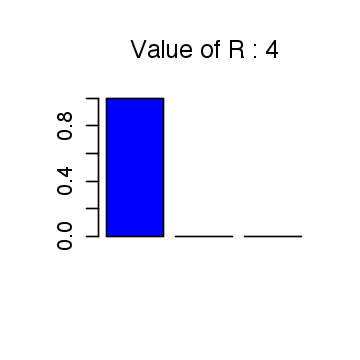

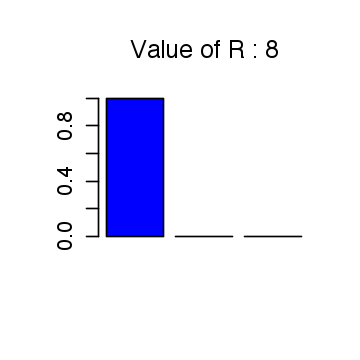

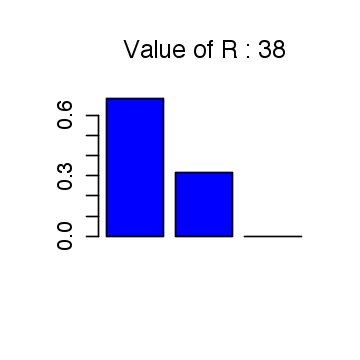

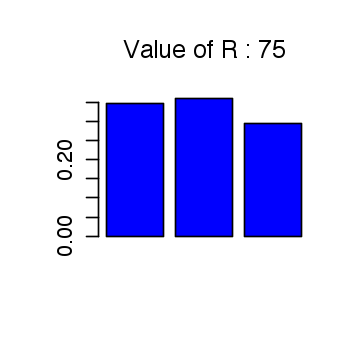

In [20]:
options(repr.plot.width=3, repr.plot.height=3)
Rlist = round(c(0.05, 0.1, 0.5, 1) * n0)

for (R in Rlist)
{
    h = hist(ys[1:R], 1:k) / R
    barplot(h, main=paste("Value of R :", R), col=4)
}

__Exercise 1__

Perform the NN classification for all the points in the test set, and for varying $R$.
Show how the classification score $S$ (number of correctly classified points)
evolves with $R$
lot(1:Rmax, S, '.-', 'MarkerSize', ms);

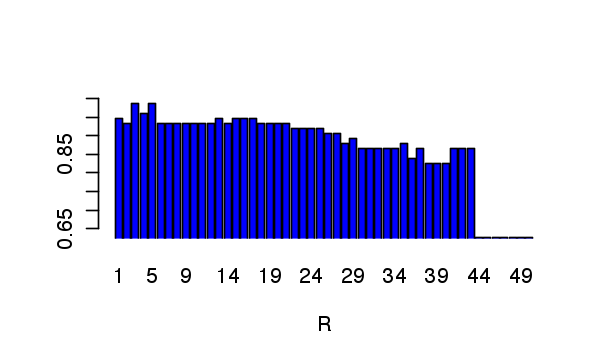

In [21]:
source("nt_solutions/ml_1_pca_nn/exo1.R")

In [22]:
## Insert your code here.

__Exercise 2__

Display, as a function of the position in 2-D PCA space, the class output by
the $R$-NN method when applied in 2-D.

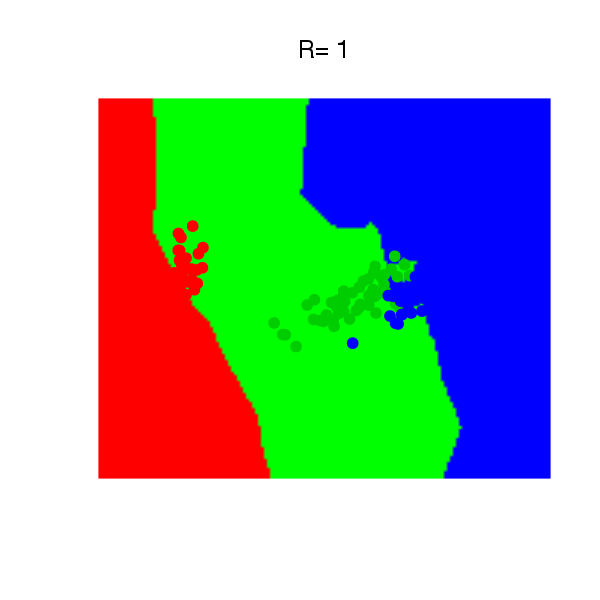

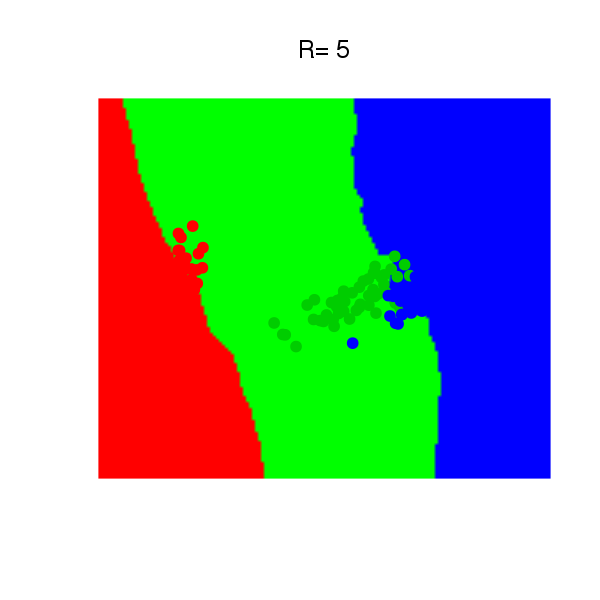

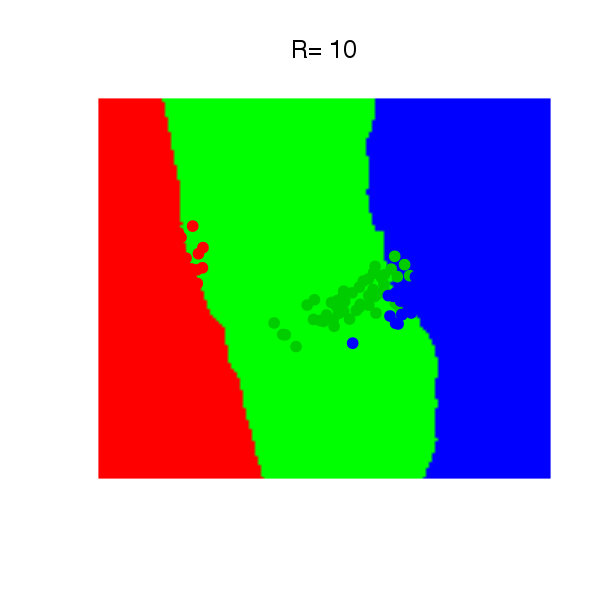

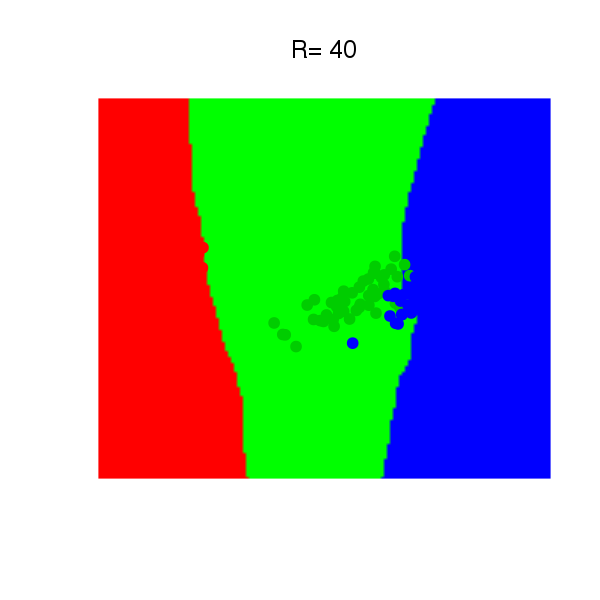

In [23]:
source("nt_solutions/ml_1_pca_nn/exo2.R")

In [24]:
## Insert your code here.

Unsupervised Learning: $k$-means
----------------------------------
In an [un-supervised setting](https://en.wikipedia.org/wiki/Unsupervised_learning), the class information $y$ is not
available. The basic problem is then to recover class information from
the knowledge of $x$ only. This corresponds to the [clustering problem](https://en.wikipedia.org/wiki/Cluster_analysis).

The most basic algorithm is the <https://en.wikipedia.org/wiki/K-means_clustering $k$-means>, which tries to recover the
class index $\bar y_i=\ell$ from the distance $ \norm{x_i-c_\ell} $
between the feature point $x_i$ and the class centroid $c_\ell$
(which are the unknown of the problem).


It does so by minimizing the following non-convex energy
  $$ \umin{ (c_\ell)_\ell } \sum_i \umin{\ell} \norm{x_i-c_\ell}^2   $$


We first initialize the class centroids $ (c_\ell)_\ell $ at random among the points.
They are stored in as the row of a matrix $ C \in \RR^{k \times p} $.

In [25]:
I = sample(n)
I = I[1:k]
C = X[I,]

The $k$-means algorithm iterate between first determining the class of
each point using the distance to the centroids
  $$ \forall i \in \{1,\ldots,n\}, \quad \bar y_i \leftarrow
          \uargmin{\ell} \norm{x_i-c_\ell}. $$

In [26]:
D = distmat(X, C)
yb = apply(D, 1, which.min)

Display the centroids and the classes using colors.
This correspodns to a Voronoi diagram segmentation in the high
dimensional space, but here the display is done in 2D.

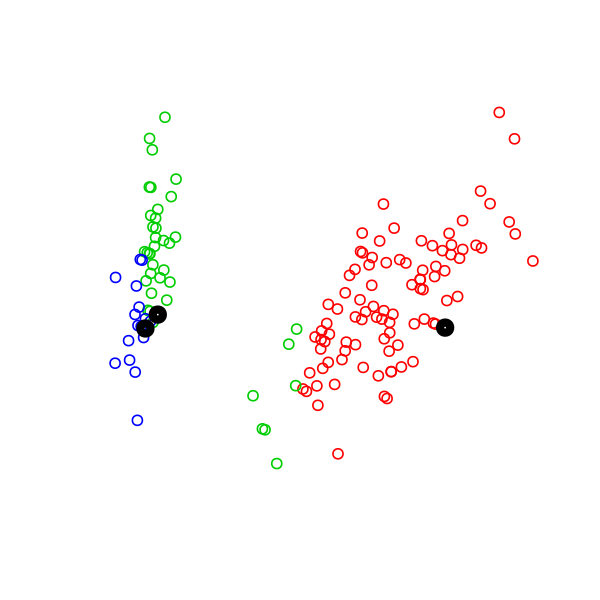

In [27]:
for (i in 1:k)
{
    I = yb==i
    plot(Z[I,1], Z[I,2], col=(i+1), xlim=c(min(Z[,1]), max(Z[,1])),  
         ylim=c(min(Z[,2]), max(Z[,2])), xaxt='n', yaxt='n', 
         ylab="", xlab="", bty="n")
    par(new=TRUE)
}

CV = (C - rep(colMeans(X), rep.int(nrow(C), ncol(X)))) %*% V

for (i in 1:k)
{
    plot(CV[i, 1], CV[i, 2], , xlim=c(min(Z[,1]), max(Z[,1])),  
         ylim=c(min(Z[,2]), max(Z[,2])), xaxt='n', yaxt='n', 
         ylab="", xlab="", lwd=5, bty="n")
    par(new=TRUE)
}

The second step of the $k$-means algorithm is to update the centroids
position to be the mean of the points inside each class
 $$ \forall \ell \in \{1,\ldots,k\}, \quad c_\ell \leftarrow
      \frac{ \sum_{i:y_i=\ell} x_i }{ \sharp \{i:y_i=\ell\} }. $$

In [28]:
for (l in 1:k)
{
    C[l,] = apply(X[yb==l,], 2, mean)
}

__Exercise 3__

Peform several step of the $k$-means algorithm.
nit

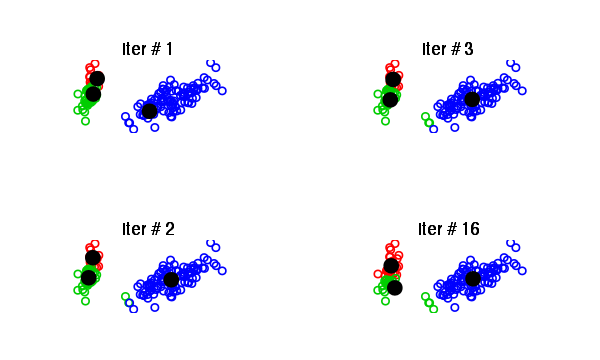

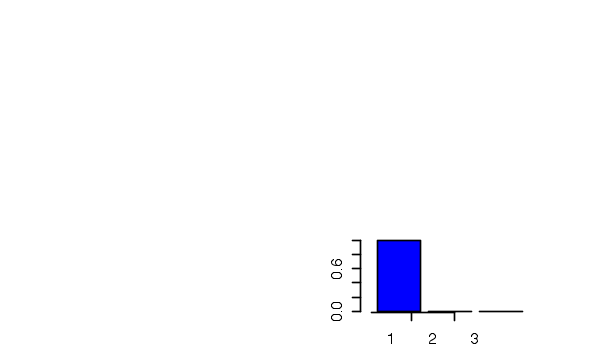

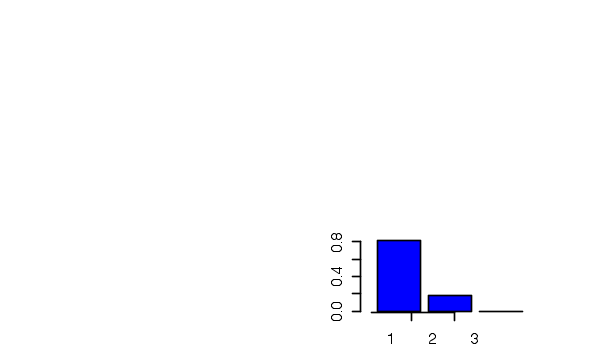

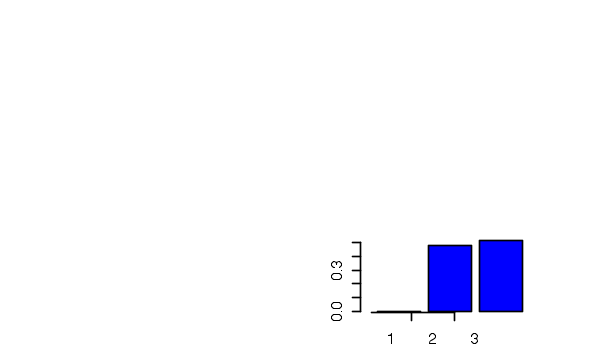

In [29]:
source("nt_solutions/ml_1_pca_nn/exo3.R")

In [30]:
## Insert your code here.

Display the histogram of (true, i.e. according to $y$) class  inside
each estimated class (i.e. according to $\bar y$).

In [31]:
# Insert your code here.

__Exercise 4__

Implement better initialization strategies such as farthest point sampling or
[$k$-means++](https://en.wikipedia.org/wiki/K-means%2B%2B).

In [32]:
source("nt_solutions/ml_1_pca_nn/exo4.R")

In [33]:
## Insert your code here.

<script>
  $(document).ready(function(){
      $('div.prompt').hide();
  });
</script>

<script>
  $(document).ready(function(){
      $('div.prompt').hide();
  });
</script>